# 1. Importing Packages

In [1]:
# importing shit
import yfinance as yf
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
from datetime import timedelta

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

In [3]:
!pip install ta

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/eshanaagarwal/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [5]:
import ta

# 2. Preparing Data

**2.a Get Stock Data**

<AxesSubplot:xlabel='Date'>

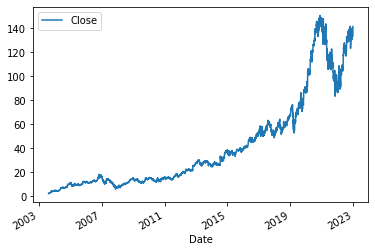

In [6]:
data = yf.Ticker("GOOG")
data = data.history(period = "max")
data.plot.line(y = "Close", use_index = True) 

In [7]:
data["Adjusted Close"] = data["Close"] - data["Dividends"]
del data["Dividends"]
del data["Stock Splits"]
data["Tomorrow"] = data["Adjusted Close"].shift(-1)
data["Target"] = (data["Tomorrow"] > data["Adjusted Close"]).astype(int)

In [8]:
data = data.loc["2004-01-01":].copy()
data

,Open,High,Low,Close,Volume,Adjusted Close,Tomorrow,Target
Date,,,,,,,,
2004-08-19 00:00:00-04:00,2.490664,2.591785,2.390042,2.499133,897427216,2.499133,2.697639,1
2004-08-20 00:00:00-04:00,2.515820,2.716817,2.503118,2.697639,458857488,2.697639,2.724787,1
2004-08-23 00:00:00-04:00,2.758411,2.826406,2.716070,2.724787,366857939,2.724787,2.611960,0
2004-08-24 00:00:00-04:00,2.770615,2.779581,2.579581,2.611960,306396159,2.611960,2.640104,1
2004-08-25 00:00:00-04:00,2.614201,2.689918,2.587302,2.640104,184645512,2.640104,2.687676,1
...,...,...,...,...,...,...,...,...
2023-12-15 00:00:00-05:00,132.919998,134.830002,132.630005,133.839996,58569400,133.839996,137.190002,1
2023-12-18 00:00:00-05:00,133.860001,138.380005,133.770004,137.190002,25699800,137.190002,138.100006,1
2023-12-19 00:00:00-05:00,138.000000,138.770004,137.449997,138.100006,20661000,138.100006,139.660004,1


**2.b Calculate Technical Indicator**

In [9]:
# Technical indicators compute

# Moving averages
data['sma'] = ta.trend.sma_indicator(data['Adjusted Close'])
data['ema'] = ta.trend.ema_indicator(data['Adjusted Close'])

# MACD
macd = ta.trend.MACD(data['Adjusted Close'])
data['MACD'] = macd.macd()
data['MACD_signal'] = macd.macd_signal()

# RSI
data['RSI'] = ta.momentum.rsi(data['Adjusted Close'])

# Bollinger Bands
bol = ta.volatility.BollingerBands(data['Adjusted Close'])
data['bollinger_high'] = bol.bollinger_hband()
data['bollinger_low'] = bol.bollinger_lband()

# Stochastic Oscillator
stochastic = ta.momentum.StochasticOscillator(high = data['High'], low = data['Low'], close = data['Adjusted Close'])
data['stochastic_oscillator'] = stochastic.stoch()

# Average True Range
data['ATR'] = ta.volatility.average_true_range(high = data['High'], low = data['Low'], close = data['Adjusted Close'])

# Ichimoku Cloud
ichimoku = ta.trend.IchimokuIndicator(high = data['High'], low = data['Low'])
data['ichimoku_a'] = ichimoku.ichimoku_a()
data['ichimoku_b'] = ichimoku.ichimoku_b()

# Pivot Points
data['pivot_point'] = (data['High'] + data['Low'] + data['Adjusted Close']) / 3
data['pivot_support'] = (2 * data['pivot_point']) - data['High']
data['pivot_resistance'] = (2 * data['pivot_point']) - data['Low']


In [10]:
# Cleaning data - dropping any missing values
data = data.dropna()

# Features-target split
X = data.drop(columns=['Adjusted Close'])
y = data['Adjusted Close']

# Random forest to compute features
model = RandomForestRegressor()
model.fit(X, y)

# Identify features that have more importance than the mean
selector = SelectFromModel(model, prefit=True)
X_selected = selector.transform(X)
selected_features = X.columns[selector.get_support()]

# Dataframe only to include the selected features and the target variable
data_selected = data[selected_features].join(data['Adjusted Close'])

data = data.dropna()


**2.c Sentiment Analysis on data**

In [11]:
# Sentiment Analysis 
url = "https://finviz.com/quote.ashx?t=GOOG&p=d"
request = Request(url = url, headers = {'user-agent' : 'my-app'})
text = urlopen(request)
text = BeautifulSoup(text, 'html')

In [12]:
news_tables = text.find(id = 'news-table')
news_rows = news_tables.findAll('tr')
date = 0
processed_data = []
for index, row in enumerate(news_rows):
    if row.a:
        timestamp = row.td.text.strip().split()
        title = row.a.text.strip()
        link = row.a.get('href')
        if len(timestamp) == 2:
            date = timestamp[0]
            time = timestamp[1]
            if date == "Today":
                date = "Dec-16-23"
        else:
            time = timestamp[0]
        processed_data.append([date, time, title, link])

In [13]:
df = pd.DataFrame(processed_data, columns = ['date', 'time', 'title', 'link'])
df['date'] = pd.to_datetime(df.date).dt.date
df

,date,time,title,link
0,2023-12-16,12:41PM,Universal Bluetooth tracker misuse standard cl...,https://finance.yahoo.com/m/47e70404-7ef4-3105...
1,2023-12-16,12:10PM,Which Magnificent 7 Stock Will Perform Best in...,https://finance.yahoo.com/m/0e25b901-cfbc-3cd0...
2,2023-12-16,10:32AM,Magnificent 7 Stocks: What You Need To Know,https://finance.yahoo.com/m/32f80df4-d63e-3dcb...
3,2023-12-16,08:42AM,This Google exec is enlisting AI to influence ...,https://finance.yahoo.com/news/google-exec-enl...
4,2023-12-16,06:24AM,Alphabet (GOOG) Outperformed Market Expectations,https://www.insidermonkey.com/blog/alphabet-go...
...,...,...,...,...
95,2023-12-18,04:39PM,Tech Tracker: Miso Robotics combines forces wi...,https://www.nrn.com/news/tech-tracker-miso-rob...
96,2023-12-18,02:56PM,"Why Alphabet, Amazon, and Other ""Magnificent S...",https://finance.yahoo.com/m/ccc4e6d3-8d25-3719...
97,2023-12-18,02:49PM,Big Techs Year of Partnering Up With AI Startups,https://finance.yahoo.com/news/big-tech-partne...
98,2023-12-18,07:57AM,"Alphabet's AI business is wildly undervalued, ...",https://www.youtube.com/watch?v=CdLdv_T842c


In [15]:
vader = SentimentIntensityAnalyzer()
scores = []
for index, row in df.iterrows():
    title = row['title']
    url = row['link']
    request = Request(url = url, headers = {'user-agent' : 'my-app'})
    text = urlopen(request)
    soup = BeautifulSoup(text, 'html')
    text = soup.find('div', {'class' : 'caas-body'})
    if text:
        scores.append(vader.polarity_scores(text.text))
    else:
        scores.append(vader.polarity_scores(title))

HTTPError: HTTP Error 404: Not Found

In [ ]:
df['sentiment_scores'] = [score['compound'] for score in scores]
df

In [ ]:
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

mean_df = df.groupby('date')[numeric_columns].mean()

plt.figure(figsize = (10,8))
mean_df.plot(kind = 'bar')
plt.show()

In [ ]:
# Final data table
data.describe()

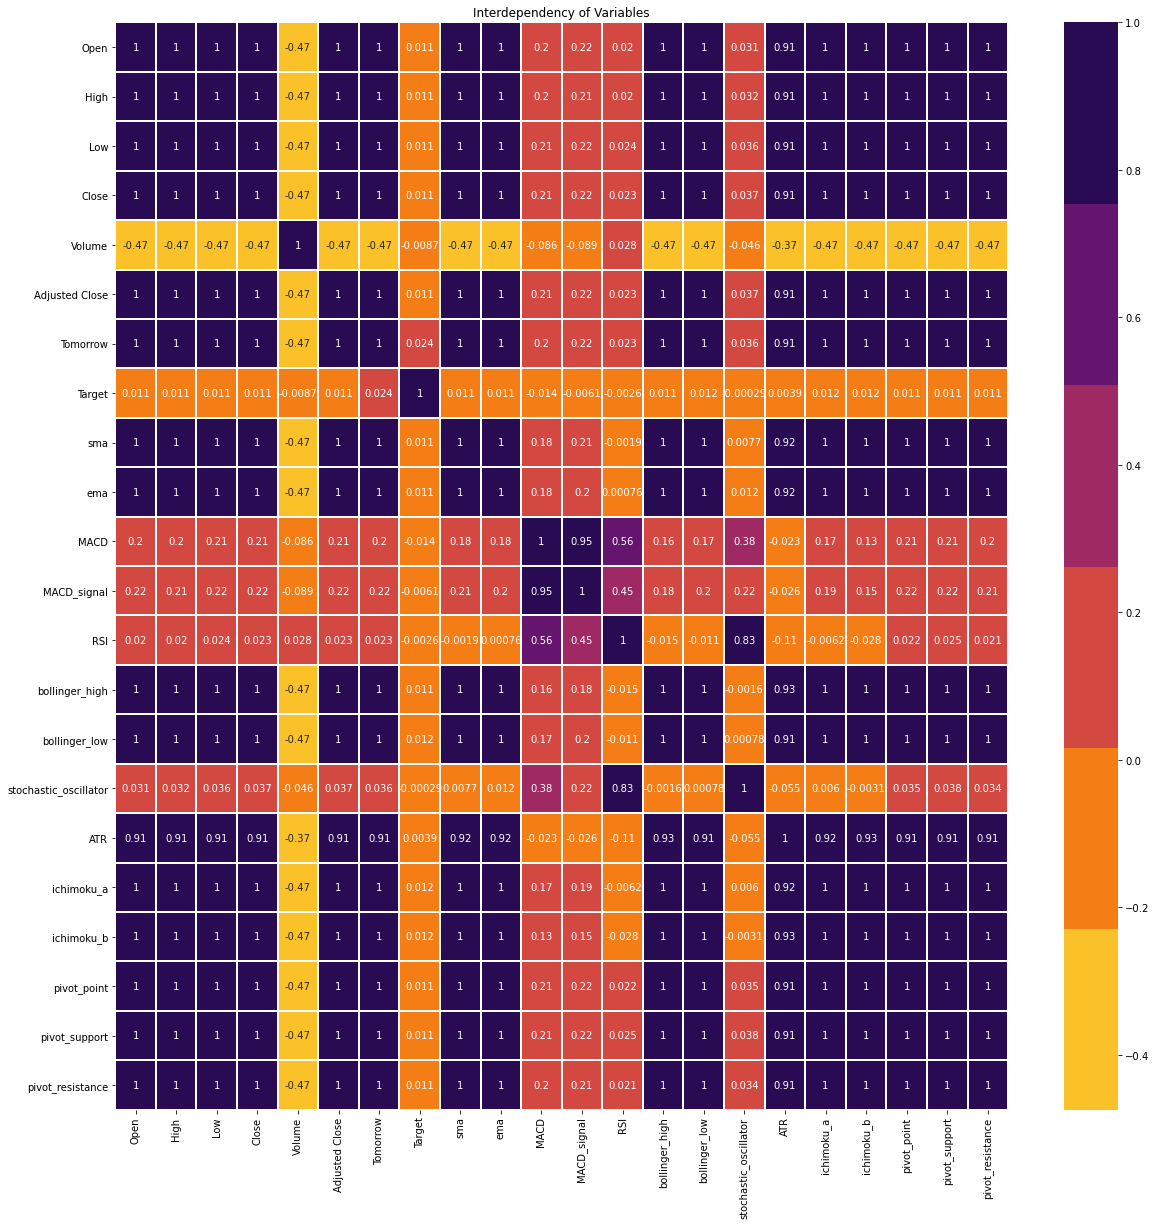

In [16]:
correlation = data.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation,annot=True,
            cmap=sns.color_palette("inferno_r"),
            linewidth=1,edgecolor="k")
plt.title("Interdependency of Variables")
plt.show()

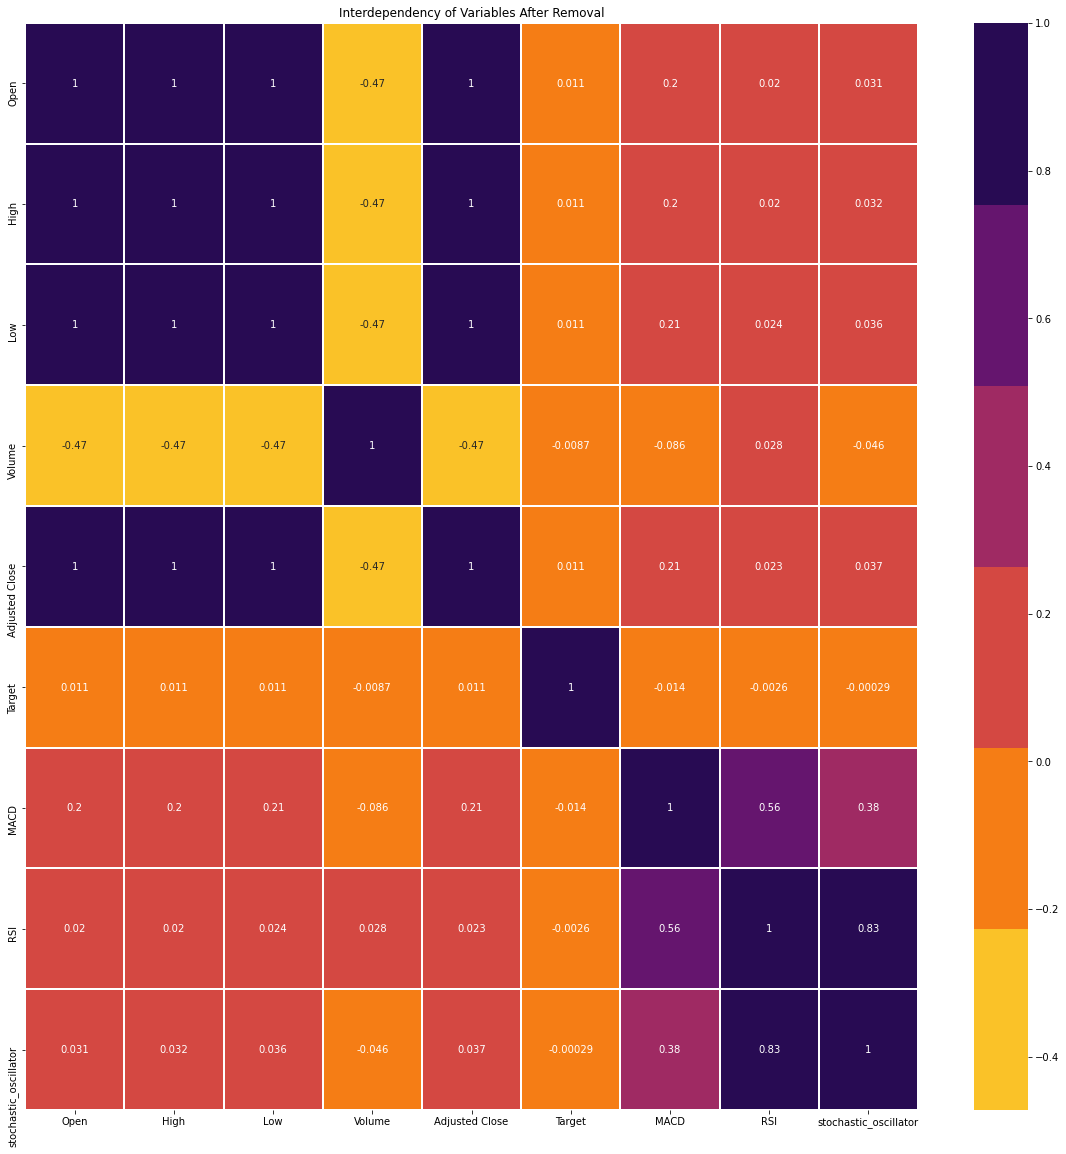

In [17]:
# Set the threshold for high correlation.
threshold = 0.9

# List of variables to exclude from removal
excluded_vars = ['Adjusted Close', 'High', 'Low']

# Identify the variables that are highly correlated and not in the exclusion list
correlated_features = set()
for i in range(len(correlation.columns)):
    for j in range(i):
        if abs(correlation.iloc[i, j]) > threshold and correlation.columns[i] not in excluded_vars:
            colname = correlation.columns[i]
            correlated_features.add(colname)

# Remove the identified features, except for the excluded ones
data = data.drop(columns=list(correlated_features - set(excluded_vars)))

# Rerun correlation matrix to check new correlations
correlation = data.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation, annot=True, cmap=sns.color_palette("inferno_r"), linewidth=1, edgecolor="k")
plt.title("Interdependency of Variables After Removal")
plt.show()


# 3. Pre-process Data

In [18]:
# training and testing split
X = np.array(data.drop(columns=['Adjusted Close'])) # features
y = np.array(data['Adjusted Close']) # target

# scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
# 95% PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)

X_train.shape:  (3868, 5)
y_train.shape:  (3868,)


In [21]:
# Variables to hold results for all ML models
max_accuracy = []

# 4. Linear Regression Models

**4.1 Linear Regression + L1 Regularization**

In [22]:
alpha = [0.2, 0.5, 1]
# no alphas below 1 allowed due to absurdly high fit (0.999+); ridge, PCA, etc not enough
accuracy = []
validation_scores = []
train_scores = []
test_scores = []
y_preds = []

In [23]:
def linearRegressionLasso(a , X_train, y_train, X_test, y_test):
    # Create an object of logistic regression model using linear_model.
  
    reg = linear_model.Lasso(alpha= a, warm_start=True,  max_iter = 5000)
    reg.fit(X_train, y_train)
    
    # Calculating what for train and test
    y_pred = reg.predict(X_test)
    y_preds.append(y_pred)
    
    # Calculating accuracy
    accuracy_val = r2_score(y_test, y_pred)
    validation_score = np.mean(cross_val_score(reg, X_train, y_train, cv=5))
    train_score = reg.score(X_train, y_train)
    test_score = reg.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    validation_scores.append(validation_score)
    accuracy.append(accuracy_val)
    
    # Printing values 
    print("For alpha = %f" % a)
    print("Accuracy on test data = %f" % accuracy_val)
    print("Validation Score = %f" % validation_score)
    print("Train Score = %f" % train_score)
    print("Test Score = %f" % test_score)

In [24]:
for i in alpha:
    linearRegressionLasso(i, X_train, y_train, X_test, y_test)  
    print()

For alpha = 0.200000
Accuracy on test data = 0.999647
Validation Score = 0.999677
Train Score = 0.999681
Test Score = 0.999647

For alpha = 0.500000
Accuracy on test data = 0.999057
Validation Score = 0.999126
Train Score = 0.999139
Test Score = 0.999057

For alpha = 1.000000
Accuracy on test data = 0.996957
Validation Score = 0.997158
Train Score = 0.997206
Test Score = 0.996957



**4.2 Hyperparameter Optimization - Lasso**

In [25]:
reg = linear_model.Lasso(warm_start=True,  max_iter = 5000)
grid = GridSearchCV(estimator = reg, param_grid= dict(alpha= alpha), scoring= 'r2', cv= 5)
grid.fit(X_train, y_train)
print(f"Best Alpha: {grid.best_estimator_.alpha}")

# Predict using the best model
y_pred = grid.predict(X_test)

# Calculate accuracy and scores
accuracy_val = r2_score(y_test, y_pred)
train_score = grid.score(X_train, y_train)
test_score = grid.score(X_test, y_test)

# Print values
print("Accuracy on test data:", accuracy_val)
print("Train Score:", train_score)
print("Test Score:", test_score)


Best Alpha: 0.2
Accuracy on test data: 0.9996473660189921
Train Score: 0.9996805064259713
Test Score: 0.9996473660189921


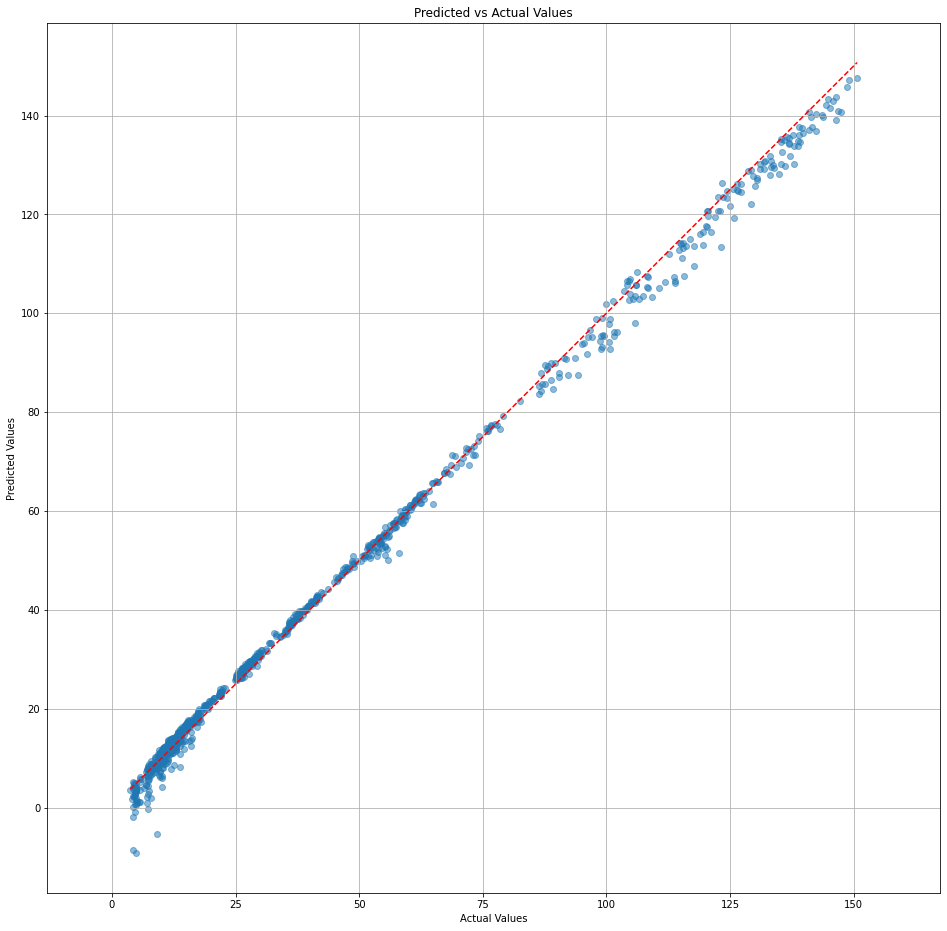

In [26]:
import matplotlib.pyplot as plt
y_pred = y_preds[2]
plt.figure(figsize=(16, 16))
plt.scatter(y_test, y_pred, alpha=0.5)  # plot the predictions vs the actual values
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # plot a 45-degree reference line

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.grid(True)
plt.axis('equal')  # Set equal scaling by changing axis limits
plt.show()

[0.2, 0.5, 1]
[0.9996805064259713, 0.9991392707965983, 0.9972062871829049]
[0.9996772643192676, 0.999126232428347, 0.9971582431822157]
[0.9996473660189921, 0.9990572943826952, 0.9969570316687247]


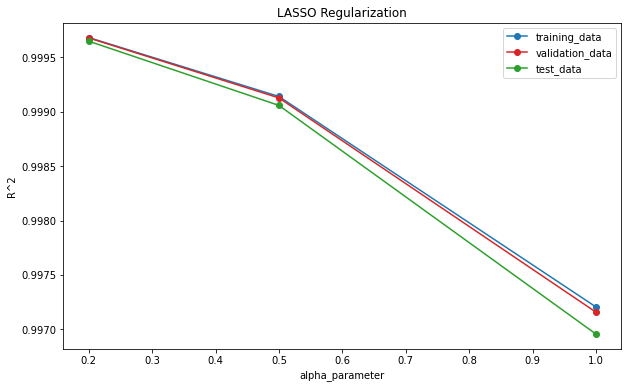

In [27]:
plt.figure(figsize=(10, 6))
print(alpha)
print(train_scores)
print(validation_scores)
print(test_scores)
plt.plot(alpha, train_scores, label='training_data', marker='o', linestyle='-', color = "tab:blue")
plt.plot(alpha, validation_scores, label='validation_data', marker='o', linestyle='-', color = "tab:red")
plt.plot(alpha, test_scores, label='test_data', marker='o', linestyle='-', color = "tab:green")

plt.xlabel('alpha_parameter')
plt.ylabel('R^2')
plt.title('LASSO Regularization')
plt.legend()
plt.show()

**4.3 Linear Regression + L2 Regularization**

In [28]:
alpha = [0.2, 0.5, 1]
accuracy = []
validation_scores = []
train_scores = []
test_scores = []
y_preds = []

In [29]:
def linearRegressionRidge(a , X_train, y_train, X_test, y_test):
    # Create an object of logistic regression model using linear_model.

    reg = linear_model.Ridge(alpha= a, solver= 'saga', random_state = 42, max_iter = 5000)
    reg.fit(X_train, y_train)

    # Calculating yhat for train and test
    y_pred = reg.predict(X_test)
    y_preds.append(y_pred)

    # Calculating accuracy
    accuracy_val = r2_score(y_test, y_pred)
    validation_score = np.mean(cross_val_score(reg, X_train, y_train, cv=5))
    train_score = reg.score(X_train, y_train)
    test_score = reg.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    validation_scores.append(validation_score)
    accuracy.append(accuracy_val)

    # Printing values
    print("For alpha = %f" % a)
    print("Accuracy on test data = %f" % accuracy_val)
    print("Validation Score = %f" % validation_score)
    print("Train Score = %f" % train_score)
    print("Test Score = %f" % test_score)

In [30]:
for i in alpha:
    linearRegressionRidge(i, X_train, y_train, X_test, y_test)
    print()

For alpha = 0.200000
Accuracy on test data = 0.999789
Validation Score = 0.999808
Train Score = 0.999809
Test Score = 0.999789

For alpha = 0.500000
Accuracy on test data = 0.999788
Validation Score = 0.999808
Train Score = 0.999809
Test Score = 0.999788

For alpha = 1.000000
Accuracy on test data = 0.999788
Validation Score = 0.999808
Train Score = 0.999809
Test Score = 0.999788



[0.9998092249017879, 0.9998092276394075, 0.9998092282026008]
[0.9998076063067363, 0.9998075967854245, 0.9998075742207078]
[0.9997885630792812, 0.9997884925653582, 0.9997883710109579]


<Figure size 432x288 with 0 Axes>

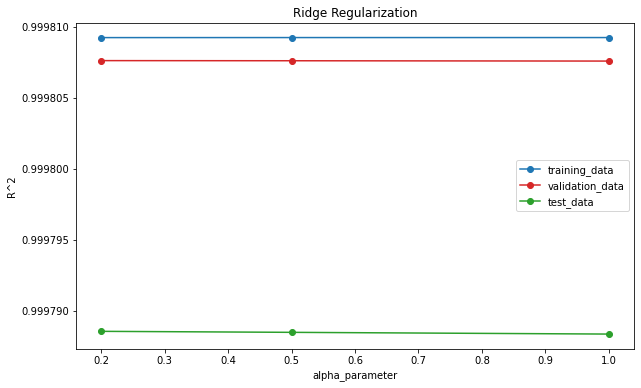

In [31]:
plt.clf()
plt.figure(figsize=(10, 6))
plt.plot(alpha, train_scores, label='training_data', marker='o', linestyle='-', color = "tab:blue")
plt.plot(alpha, validation_scores, label='validation_data', marker='o', linestyle='-', color = "tab:red")
plt.plot(alpha, test_scores, label='test_data', marker='o', linestyle='-', color = "tab:green")

print(train_scores)
print(validation_scores)
print(test_scores)

plt.xlabel('alpha_parameter')
plt.ylabel('R^2')
plt.title('Ridge Regularization')
plt.legend()
plt.show()

In [32]:
reg = linear_model.Ridge(solver= 'saga', random_state = 42, max_iter = 5000)
grid = GridSearchCV(estimator = reg, param_grid= dict(alpha= alpha), scoring= 'r2', cv= 5)
grid.fit(X_train, y_train)
print(f"Best Alpha: {grid.best_estimator_.alpha}")

# Predict using the best model
y_pred = grid.predict(X_test)

# Calculate accuracy and scores
accuracy_val = r2_score(y_test, y_pred)
train_score = grid.score(X_train, y_train)
test_score = grid.score(X_test, y_test)

# Print values
print("Accuracy on test data:", accuracy_val)
print("Train Score:", train_score)
print("Test Score:", test_score)

Best Alpha: 0.2
Accuracy on test data: 0.9997885630792812
Train Score: 0.9998092249017879
Test Score: 0.9997885630792812


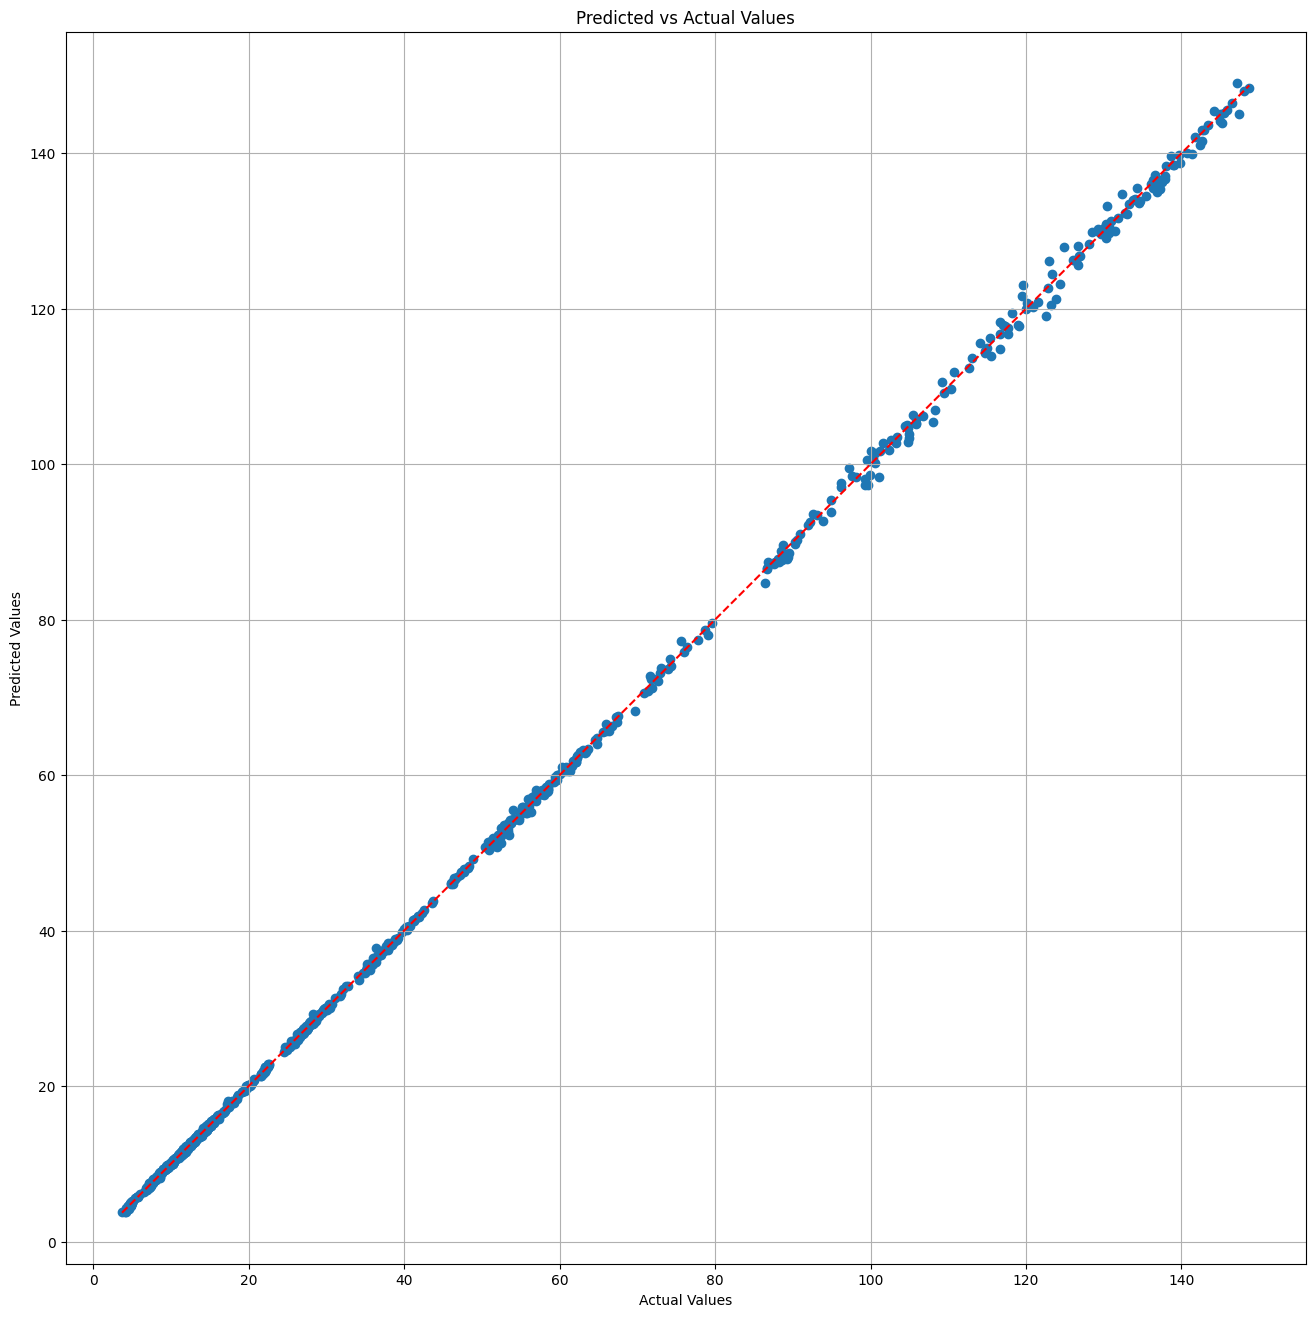

In [416]:
y_pred = y_preds[2]
plt.figure(figsize=(16, 16))
plt.scatter(y_test, y_pred, alpha=1)  # plot the predictions vs the actual values
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # plot a 45-degree reference line

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.grid(True)
plt.axis('equal')  # Set equal scaling by changing axis limits
plt.show()

   # 5: Prediction of Stock Market

In [70]:
# creating a 7-day future data frame
last_date = pd.to_datetime(data.index[-1])
prediction_dates = [last_date + timedelta(days=i) for i in range(1, 8)]
future_data = pd.DataFrame(prediction_dates, columns=['Date'])

In [71]:
future_data

,Date
0,2023-12-21 00:00:00-05:00
1,2023-12-22 00:00:00-05:00
2,2023-12-23 00:00:00-05:00
3,2023-12-24 00:00:00-05:00
4,2023-12-25 00:00:00-05:00
5,2023-12-26 00:00:00-05:00
6,2023-12-27 00:00:00-05:00


In [72]:
last_values = data.iloc[-7:]
last_values

,Open,High,Low,Volume,Adjusted Close,Target,MACD,RSI,stochastic_oscillator
Date,,,,,,,,,
2023-12-12 00:00:00-05:00,133.270004,134.539993,132.830002,26584000,133.639999,1,0.020943,47.566434,36.239325
2023-12-13 00:00:00-05:00,134.544998,134.779999,132.949997,25414500,133.970001,0,-0.051429,48.267144,43.113252
2023-12-14 00:00:00-05:00,134.770004,135.035004,131.059998,29619100,133.199997,1,-0.168969,46.698959,35.849065
2023-12-15 00:00:00-05:00,132.919998,134.830002,132.630005,58569400,133.839996,1,-0.208080,48.205228,41.886791
2023-12-18 00:00:00-05:00,133.860001,138.380005,133.770004,25699800,137.190002,1,0.030886,55.322401,73.490604
2023-12-19 00:00:00-05:00,138.000000,138.770004,137.449997,20661000,138.100006,1,0.290352,57.048944,82.075540
2023-12-20 00:00:00-05:00,140.330002,143.078003,139.410004,33507300,139.660004,1,0.614772,59.909158,75.010988


In [73]:
for column in last_values:
    if column != 'Date':
        future_data[column] = last_values[column].values

In [74]:
future_data

,Date,Open,High,Low,Volume,Adjusted Close,Target,MACD,RSI,stochastic_oscillator
0,2023-12-21 00:00:00-05:00,133.270004,134.539993,132.830002,26584000,133.639999,1,0.020943,47.566434,36.239325
1,2023-12-22 00:00:00-05:00,134.544998,134.779999,132.949997,25414500,133.970001,0,-0.051429,48.267144,43.113252
2,2023-12-23 00:00:00-05:00,134.770004,135.035004,131.059998,29619100,133.199997,1,-0.168969,46.698959,35.849065
3,2023-12-24 00:00:00-05:00,132.919998,134.830002,132.630005,58569400,133.839996,1,-0.208080,48.205228,41.886791
4,2023-12-25 00:00:00-05:00,133.860001,138.380005,133.770004,25699800,137.190002,1,0.030886,55.322401,73.490604
5,2023-12-26 00:00:00-05:00,138.000000,138.770004,137.449997,20661000,138.100006,1,0.290352,57.048944,82.075540
6,2023-12-27 00:00:00-05:00,140.330002,143.078003,139.410004,33507300,139.660004,1,0.614772,59.909158,75.010988


In [89]:
len(X_train[0])

5

In [75]:
future_data = future_data.drop(columns=['Adjusted Close'])
future_data

,Date,Open,High,Low,Volume,Target,MACD,RSI,stochastic_oscillator
0,2023-12-21 00:00:00-05:00,133.270004,134.539993,132.830002,26584000,1,0.020943,47.566434,36.239325
1,2023-12-22 00:00:00-05:00,134.544998,134.779999,132.949997,25414500,0,-0.051429,48.267144,43.113252
2,2023-12-23 00:00:00-05:00,134.770004,135.035004,131.059998,29619100,1,-0.168969,46.698959,35.849065
3,2023-12-24 00:00:00-05:00,132.919998,134.830002,132.630005,58569400,1,-0.208080,48.205228,41.886791
4,2023-12-25 00:00:00-05:00,133.860001,138.380005,133.770004,25699800,1,0.030886,55.322401,73.490604
5,2023-12-26 00:00:00-05:00,138.000000,138.770004,137.449997,20661000,1,0.290352,57.048944,82.075540
6,2023-12-27 00:00:00-05:00,140.330002,143.078003,139.410004,33507300,1,0.614772,59.909158,75.010988


In [92]:
# using the best found parameters
reg = linear_model.Ridge(alpha= 0.2, solver= 'saga', random_state = 42, max_iter = 5000)
reg.fit(X_train, y_train)

X = np.array(future_data.drop(columns = ['Date'])) # features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

y = reg.predict(X_pca)

array([[-1.60915155,  0.0434818 , -0.70243138, -0.66521625],
       [-1.60022971,  2.15756787,  1.04522824,  0.24285169],
       [-1.97839472, -0.12909221, -0.59219907, -0.69050537],
       [-2.20149986, -1.91459224,  0.95334775,  0.41124873],
       [ 0.57022598, -0.08784342, -0.94767023,  1.03199298],
       [ 2.56849752,  0.35801461, -0.57899406,  0.19425649],
       [ 4.25055233, -0.42753642,  0.82271876, -0.52462827]])

In [ ]:
y